<a href="https://colab.research.google.com/github/saishshinde15/Langchain_RAG_BOT/blob/main/Agent_VectorDB_Using_LangGraph_LangChain(v3_documentation)_selfwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain langchain_community

In [2]:
%pip install -qU langchain_community pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 9.3 MB/s eta 0:00:00


In [3]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(
    "/content/HAI_AI-Index-Report-2024.pdf",
)

In [4]:
docs = loader.load()

In [5]:
%pip install -qU langchain-text-splitters

In [7]:
from langchain_text_splitters import CharacterTextSplitter
text_splitter = CharacterTextSplitter(
    separator="\n\n",
    chunk_size=1000,
    chunk_overlap=0)
docs=text_splitter.split_documents(docs)

In [8]:
%pip install --upgrade --quiet  langchain sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 11.7 MB/s eta 0:00:00


In [11]:
import getpass

inference_api_key = getpass.getpass("Enter your HF Inference API Key:\n\n")

Enter your HF Inference API Key:

··········


In [12]:
from langchain_community.embeddings import HuggingFaceInferenceAPIEmbeddings

embeddings = HuggingFaceInferenceAPIEmbeddings(
    api_key=inference_api_key, model_name="sentence-transformers/all-MiniLM-l6-v2"
)


/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in HuggingFaceInferenceAPIEmbeddings has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [13]:
pip install -qU langchain-community faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 44.8 MB/s eta 0:00:00


In [15]:
from langchain_community.vectorstores import FAISS
vector = FAISS.from_documents(docs, embeddings)
retriever = vector.as_retriever()

In [16]:
from langchain.tools.retriever import create_retriever_tool

In [17]:
retriever_tool = create_retriever_tool(
    retriever,
    "AI_search",
    "Search for information about AI report from the stored pdf. For any questions about the report, you must use this tool!",
)

In [18]:
%pip install -qU "langchain-community>=0.2.11" tavily-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.8 MB/s eta 0:00:00


In [19]:
import getpass
import os

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

Tavily API key:
··········


In [20]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [21]:
search_tool = TavilySearchResults(max_results=2,search_depth="advanced")

In [22]:
def search(query: str) -> str:
    """Use Tavily to search for the query.
    Args:
        query: The query to search for.
    """
    return search_tool.run(query)

def AI_search(query: str) -> str:
    """Search for information about AI report from the stored pdf.
    For any questions about the report, you must use this tool!
    Args:
        query: The query to search for.
    """
    return retriever_tool.run(query)


In [24]:
pip install -qU langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 6.2 MB/s eta 0:00:00


In [25]:
import getpass
import os

os.environ["GROQ_API_KEY"] = getpass.getpass()

from langchain_groq import ChatGroq

model = ChatGroq(model="llama3-8b-8192")

··········


In [26]:
tools=[retriever_tool,search_tool]
llm_with_tools=model.bind_tools(tools)

In [27]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [53]:
# Method 1 (Only run one of the methods)
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message # can you other prompts such as ChatPromptTemplete , SystemMessagePromoptTemplete
sys_msg = SystemMessage(content="You are a helpful assistant tasked with answering any questions related to the document and AI. You should only provide the main answer and not include additional context or explanations.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [48]:
# Method 2
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate

# Define the system message prompt template
sys_msg_template = SystemMessagePromptTemplate.from_template(
    "You are a helpful assistant tasked with answering any questions related to the document and AI. "
    "You should only provide the main answer and not include additional context or explanations."
)

# Example of a human message and ai message
example_human_msg = HumanMessage(content="Can you explain the latest trends in AI?")
example_ai_msg = SystemMessage(content="The latest trends in AI include advancements in generative AI, reinforcement learning, and explainability in AI models.")

# Node function for handling the assistant's response
def assistant(state: MessagesState):
    # Generate a response based on the system message template and provided state messages
    return {
        "messages": [llm_with_tools.invoke([sys_msg_template.format()] + state["messages"])]
    }

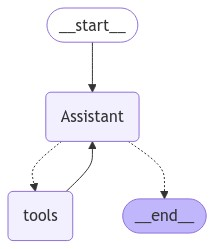

In [54]:
# creating a ReAct agent
build=StateGraph(MessagesState)
build.add_node("Assistant",assistant,)
build.add_node("tools",ToolNode(tools))
build.add_edge(START,"Assistant")
build.add_conditional_edges("Assistant",tools_condition)
build.add_edge("tools","Assistant")
react_graph = build.compile()
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [55]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = build.compile(checkpointer=memory)

In [70]:
# Specify a thread
config = {"configurable": {"thread_id": "3"}}

# Specify an input
messages = [HumanMessage(content="What is AI?")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is AI?
================================== Ai Message ==================================
Tool Calls:
  AI_search (call_7y8n)
 Call ID: call_7y8n
  Args:
    query: What is AI
================================= Tool Message =================================
Name: AI_search

29Artificial Intelligence
Index Report 2024CHAPTER 1:
Research and 
Development
Overview
This chapter studies trends in AI research and development. It begins by examining 
trends in AI publications and patents, and then examines trends in notable AI systems and 
foundation models. It concludes by analyzing AI conference attendance and open-source 
AI software projects.
Table of Contents

Artificial Intelligence
Index Report 2024459459 Table of ContentsChapter 1  Research and Development 460
Chapter 2  Technical Performance 465
Chapter 3  Responsible AI 472
Chapter 4  Economy 478
Chapter 5  Science and Medicine 488
Chapter 6  Educati

In [71]:
messages = [HumanMessage(content="Is the report about AI?")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is AI?
================================== Ai Message ==================================
Tool Calls:
  AI_search (call_7y8n)
 Call ID: call_7y8n
  Args:
    query: What is AI
================================= Tool Message =================================
Name: AI_search

29Artificial Intelligence
Index Report 2024CHAPTER 1:
Research and 
Development
Overview
This chapter studies trends in AI research and development. It begins by examining 
trends in AI publications and patents, and then examines trends in notable AI systems and 
foundation models. It concludes by analyzing AI conference attendance and open-source 
AI software projects.
Table of Contents

Artificial Intelligence
Index Report 2024459459 Table of ContentsChapter 1  Research and Development 460
Chapter 2  Technical Performance 465
Chapter 3  Responsible AI 472
Chapter 4  Economy 478
Chapter 5  Science and Medicine 488
Chapter 6  Educati

In [72]:
messages = [HumanMessage(content="What is the title of the report and who wrote it?")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is AI?
================================== Ai Message ==================================
Tool Calls:
  AI_search (call_7y8n)
 Call ID: call_7y8n
  Args:
    query: What is AI
================================= Tool Message =================================
Name: AI_search

29Artificial Intelligence
Index Report 2024CHAPTER 1:
Research and 
Development
Overview
This chapter studies trends in AI research and development. It begins by examining 
trends in AI publications and patents, and then examines trends in notable AI systems and 
foundation models. It concludes by analyzing AI conference attendance and open-source 
AI software projects.
Table of Contents

Artificial Intelligence
Index Report 2024459459 Table of ContentsChapter 1  Research and Development 460
Chapter 2  Technical Performance 465
Chapter 3  Responsible AI 472
Chapter 4  Economy 478
Chapter 5  Science and Medicine 488
Chapter 6  Educati

In [73]:
messages = [HumanMessage(content="Does the report have anything about ExplainableAI?")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is AI?
================================== Ai Message ==================================
Tool Calls:
  AI_search (call_7y8n)
 Call ID: call_7y8n
  Args:
    query: What is AI
================================= Tool Message =================================
Name: AI_search

29Artificial Intelligence
Index Report 2024CHAPTER 1:
Research and 
Development
Overview
This chapter studies trends in AI research and development. It begins by examining 
trends in AI publications and patents, and then examines trends in notable AI systems and 
foundation models. It concludes by analyzing AI conference attendance and open-source 
AI software projects.
Table of Contents

Artificial Intelligence
Index Report 2024459459 Table of ContentsChapter 1  Research and Development 460
Chapter 2  Technical Performance 465
Chapter 3  Responsible AI 472
Chapter 4  Economy 478
Chapter 5  Science and Medicine 488
Chapter 6  Educati

In [74]:
messages = [HumanMessage(content="Can you search and tell me what is ExplainableAI?")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is AI?
================================== Ai Message ==================================
Tool Calls:
  AI_search (call_7y8n)
 Call ID: call_7y8n
  Args:
    query: What is AI
================================= Tool Message =================================
Name: AI_search

29Artificial Intelligence
Index Report 2024CHAPTER 1:
Research and 
Development
Overview
This chapter studies trends in AI research and development. It begins by examining 
trends in AI publications and patents, and then examines trends in notable AI systems and 
foundation models. It concludes by analyzing AI conference attendance and open-source 
AI software projects.
Table of Contents

Artificial Intelligence
Index Report 2024459459 Table of ContentsChapter 1  Research and Development 460
Chapter 2  Technical Performance 465
Chapter 3  Responsible AI 472
Chapter 4  Economy 478
Chapter 5  Science and Medicine 488
Chapter 6  Educati

In [75]:
# resources used Creating_Agent_LangGraph.ipynb from drive and langchain-academy/module-1/agent.ipynb and langchain latest documentation v3

In [76]:
# Langsmit for tracing

In [77]:
LANGCHAIN_TRACING_V2=True
LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
LANGCHAIN_API_KEY="API_KEY"
LANGCHAIN_PROJECT="default"